# Beginner-Friendly Machine Learning Tutorial: Iris Dataset

Welcome! This notebook will guide you step-by-step through a hands-on machine learning workflow using the classic Iris dataset. You will learn how to:

- Load and explore data
- Preprocess and clean data
- Build and evaluate a machine learning model
- Visualize results

Let's get started!

In [1]:
# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

# Chemin absolu vers le dossier racine du projet
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 1. Setup: Import Libraries and Configure Environment

Before we start, let's import the necessary Python libraries and set up our environment. This ensures we have all the tools needed for data analysis and machine learning.

In [2]:
import seaborn as sns  # statistical data visualization built on Matplotlib
import matplotlib.pyplot as plt  # plotting library for Python
import numpy as np  # numerical operations
import pandas as pd  # data manipulation and analysis library
from sklearn.ensemble import RandomForestRegressor  # regression model for feature importance
from sklearn.preprocessing import LabelEncoder  # encode categorical labels as numbers
from sklearn.model_selection import train_test_split  # split data into train/test sets
from sklearn.metrics import classification_report, confusion_matrix  # model evaluation metrics
# Import all functions from src.utility (custom utility functions for this project)
from src.utility import *  # utility functions for data processing and visualization
from sklearn.pipeline import Pipeline  # build machine learning pipelines
from sklearn.ensemble import RandomForestClassifier  # classification model

### About the Custom Machine Learning Classes

This notebook uses several custom classes from `utility.py` to simplify and enhance the machine learning workflow:

- **MetaCleanPipeline**: A high-level pipeline that automates data cleaning, feature engineering, and target encoding. It helps you quickly prepare your data for modeling.
- **FeatureEngineeringSelector**: Allows you to apply different feature selection and engineering strategies, such as model-based selection or PCA, in a flexible way.
- **DataCleaner**: Handles missing values, scaling, encoding, and duplicate removal, making your data ready for machine learning algorithms.
- **GraphAnalyzerEngine**: Analyzes feature importances and relationships, making it easy to interpret which features matter most.
- **VisualizerFactory**: Provides advanced visualizations (Sankey diagrams, bar plots, radar plots, t-SNE) to help you understand your data and model results.

These tools are designed to make the machine learning process more accessible and interpretable for beginners.

## 2. Load and Explore the Iris Dataset

The Iris dataset is a classic in machine learning, containing measurements of 150 iris flowers from three different species. Let's load the data and take a first look at its structure.

In [3]:
iris = sns.load_dataset("iris")  # load the iris dataset (150 samples, 4 features, 3 species)
iris.head()  # display the first few rows of the dataset to understand its structure

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## 3. Data Preprocessing: Feature Selection and Cleaning

To prepare our data for machine learning, we need to:
- Separate features (inputs) from the target (output)
- Clean and preprocess the data (handle missing values, encode categories, etc.)

We'll use a custom pipeline to automate these steps.

In [4]:
# Separate features (X) and target (y)
X = iris.drop(columns=["species"])  # features: sepal length, sepal width, petal length, petal width
y = iris["species"]  # target variable: species name


In [5]:
# Create and configure the data cleaning and feature engineering pipeline
meta_pipe = MetaCleanPipeline(
    drop_duplicates=True, 
    feature_engineering_strategies=[{
        "name": "model_importance", 
        "model_cls": RandomForestRegressor, 
        "threshold": "mean"
    }],
    numeric_strategy='drop', 
    categorical_strategy='drop',
    target_encoder_cls=LabelEncoder,
)

# Fit the pipeline and transform the data
# The pipeline automatically encodes the target and selects important features
X_clean = meta_pipe.fit_transform(X, y)
print(X_clean.head())
print("Features finales :", meta_pipe.get_selected_features())

# Retrieve cleaned features and encoded target for training
X_cleaned, y_enc = meta_pipe.get_cleaned_dataset()
y_original = meta_pipe.inverse_transform_target(y_enc)
print("y_original unique :", np.unique(y_original))
print("y_enc unique :", np.unique(y_enc))
print('shape X_cleaned:', X_cleaned.shape)
print('shape y_enc:', y_enc.shape)
y_full_enc = meta_pipe.transform_target(y_original)

# If you want to decode y_enc back to original labels:
print(meta_pipe.inverse_transform_target(np.unique(y_enc)))

TypeError: __init__() got an unexpected keyword argument 'target_encoder_cls'

## 4. Model Training and Evaluation

Now, let's train a machine learning model to classify iris species. We'll:
- Split the data into training and test sets
- Train a Random Forest classifier
- Evaluate the model's performance using a classification report and confusion matrix

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      1.00      1.00        11
   virginica       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



Text(51.0, 0.5, 'Actual')

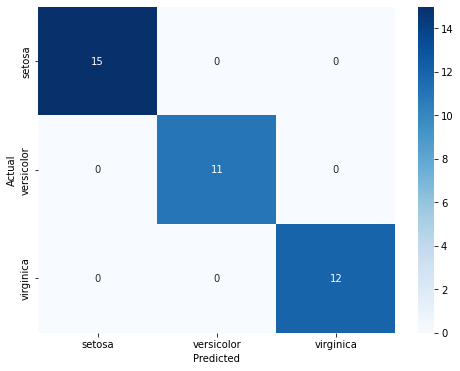

In [ ]:
# Build a simple machine learning pipeline with a Random Forest classifier
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Split the data into training and test sets (default: 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_cleaned[meta_pipe.get_selected_features()],
                                                    y_original, random_state=42)
# Train the model
pipe.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipe.predict(X_test)

# Print a detailed classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_original), yticklabels=np.unique(y_original), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## 5. Feature Importance and Visualization

Understanding which features are most important helps us interpret our model. We'll use advanced visualizations (Sankey diagram and bar plot) to explore feature importances and relationships.

### Sankey Diagram
A Sankey diagram will help us visualize the flow of data through our model, showing how features contribute to predictions.

In [ ]:
# Analyze feature importances and relationships using a custom engine
engine = GraphAnalyzerEngine()
engine.analyze(X_cleaned, pd.DataFrame(y_enc))  # y_enc = encoded target
store = engine.get_store()  # Get the ImportanceResultStore object
label_map = dict(enumerate(meta_pipe.get_target_encoder().classes_))
relabel_targets_in_store(store, label_map)  # Make target labels human-readable

# Create and display a Sankey diagram to visualize feature-to-target relationships
fig_sankey = VisualizerFactory.make_sankey(store, show_feature_feature_links=False)
fig_sankey.show()

### Bar Plot of Feature Importances

The bar plot below shows the aggregated importance of each feature. The dashed line represents the threshold for random (noise) importance. Features above this line are considered informative.

In [ ]:
# Create and display a bar plot of feature importances
# Features above the dashed line are considered informative
fig_bar = VisualizerFactory.make_bar(store, show_threshold=True, show_noise=True)
fig_bar.show()

## 6. Conclusion and Next Steps

Congratulations! You have completed a full machine learning workflow:
- Data loading and exploration
- Preprocessing and cleaning
- Model training and evaluation
- Feature importance analysis and visualization

Feel free to experiment with different models, parameters, or datasets. Happy learning!